In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from Bio import SeqIO
from pathlib import Path
from sklearn.manifold import TSNE

In [3]:
# add src code to system path
import sys
sys.path.append("src")
from LocalDirichletEnergy import get_local_dirichlet_energy
from Utils import get_representations

# Loading cutinase data

In [4]:
# load cutinase data
df = pd.read_csv("data/cutinase_fitness.csv")

In [5]:
# add aligned data to df
aln_seq_ls = [
    str(fasta_seq.seq).upper().rstrip()
    for fasta_seq in SeqIO.parse("./data/cutinase_sequences_ALN.fasta", "fasta")
]
aln_names_ls = [
    str(fasta_seq.id)
    for fasta_seq in SeqIO.parse("./data/cutinase_sequences_ALN.fasta", "fasta")
]
df = df.merge(pd.DataFrame({"Name": aln_names_ls, "Aln_sequence": aln_seq_ls}), on="Name")

In [6]:
name_ls = df["Name"].tolist()
seq_ls = df["Sequence"].tolist()

phases = df.Phase.tolist()
names = df.Name.tolist()

mean = df["Scaled Average Absorbance  (control subtracted)"].to_numpy()
stdev = df["Scaled SD of Mean  (control subtracted)"].to_numpy()
seq_ls = df.Sequence.tolist()
aln_seq_ls = df["Aln_sequence"].tolist()

In [7]:
print(f"Number of sequences: {len(seq_ls)}")

Number of sequences: 196


# Get sequence embeddings

OHE embeddings:

In [8]:
# get ohe embeddings for aligned sequences
aa_ls = [
    'A', 'C', 'D', 'E', 'F','G', 'H', 'I', 'K', 'L',
    'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'
]

ohe_dict = {}
for i, aa in enumerate(aa_ls):
    arr_idx = np.zeros((len(aa_ls)))
    arr_idx[i] = 1
    ohe_dict[aa] = arr_idx
ohe_dict["-"] = np.zeros((len(aa_ls)))

In [9]:
ohe_seqs = []
for seq in aln_seq_ls:
    seq_ohe = []
    for aa in seq:
        ohe_aa = ohe_dict[aa]
        seq_ohe.append(ohe_aa)
    ohe_seqs.append(np.array(seq_ohe).flatten())
ohe_seqs = np.array(ohe_seqs)

LASE embeddings:

In [11]:
lase_seqs = get_representations(
    seq_ls,
    Path("models/final_epoch_model.pt"),
    32,
    64,
    2,
    0.1,
    3,
)

/Users/u5802006/cutinase_ruggedness/src/DataProc.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.inputs.items()}


Prepare for plotting:

In [12]:
print(df.Phase.unique())

['II - ASR' 'V - Alternate Reconstructions' 'I - Extants, Designs, ICCG'
 'IX - Recombinations' 'N205C/S252C']


In [13]:
# palette for phase coloring
phase_palette = {
    'II - ASR': '#4387C7',
    'V - Alternate Reconstructions': '#00B192',
    'I - Extants, Designs, ICCG': '#D35227',
    'IX - Recombinations': '#7F52A1',
    'N205C/S252C': '#456845', 
}

# OHE TSNE

In [14]:
tsne = TSNE(
    random_state=0, 
    perplexity=30, 
    init="random",
    learning_rate=200,
)

res = tsne.fit_transform(ohe_seqs)

x_ohe = res[:, 0]
y_ohe = res[:, 1]

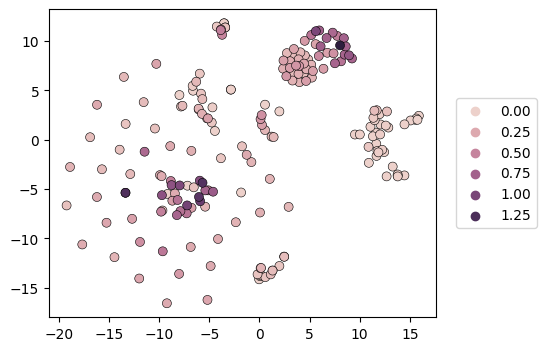

In [15]:
fig, ax = plt.subplots(figsize=(5, 4))
mean_sort = np.argsort(mean)
sns.scatterplot(x=x_ohe[mean_sort], y=y_ohe[mean_sort], hue=mean[mean_sort], s=42, edgecolor="black", linewidth=0.4, ax=ax)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)
plt.savefig("./figures/ohe_activity.pdf", bbox_inches='tight')
plt.show()

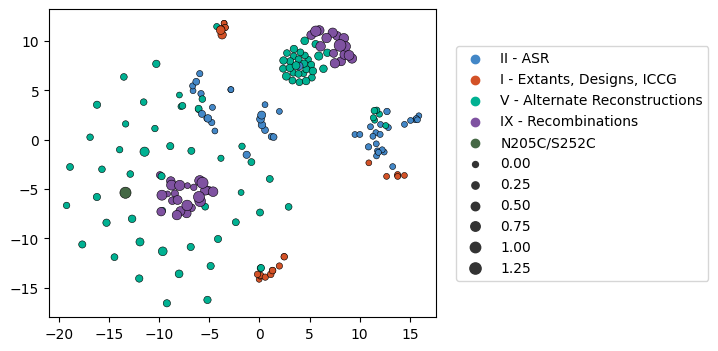

In [16]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(
    x=x_ohe[mean_sort], 
    y=y_ohe[mean_sort], 
    hue=np.array(phases)[mean_sort].tolist(), 
    size=mean[mean_sort], 
    edgecolor="black", linewidth=0.4, ax=ax,
    palette=phase_palette,
)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
plt.savefig("./figures/ohe_phase.pdf", bbox_inches='tight')
plt.show()

# OHE Local Dirichlet Energy

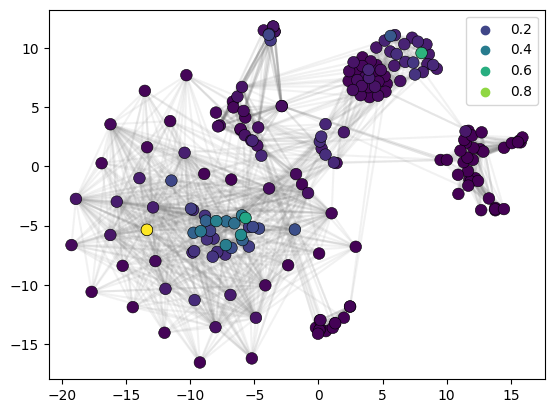

In [17]:
local_ens, local_edge_ls = get_local_dirichlet_energy(ohe_seqs, np.array(mean))

# plot each edge
for i in range(len(local_edge_ls)):
    for idx in local_edge_ls[i][0]:
        plt.plot([x_ohe[i], x_ohe[idx]], [y_ohe[i], y_ohe[idx]], color="grey", alpha=0.05)

local_ens_sort = np.argsort(local_ens)

sns.scatterplot(
    x=x_ohe[local_ens_sort], 
    y=y_ohe[local_ens_sort],
    hue=np.array(local_ens)[local_ens_sort],
    zorder=5,
    palette="viridis",
    s=70,
    edgecolor="black", linewidth=0.4, 
)
plt.savefig("./figures/ohe_dirichlet_energies.pdf", bbox_inches='tight')
plt.show()

In [18]:
# order of energies and coords
ohe_energy_dict = {
    "Name": [],
    "Phase": [],
    "Fitness": [],
    "Local energy": [],
    "LASE tSNE x": [],
    "LASE tSNE y": []
}
for i in np.flip(local_ens_sort):
    ohe_energy_dict["Name"].append(name_ls[i])
    ohe_energy_dict["Phase"].append(phases[i])
    ohe_energy_dict["Fitness"].append(mean[i])
    ohe_energy_dict["Local energy"].append(np.round(local_ens[i], 4))
    ohe_energy_dict["LASE tSNE x"].append(np.round(x_ohe[i], 4))
    ohe_energy_dict["LASE tSNE y"].append(np.round(y_ohe[i], 4))

pd.DataFrame(ohe_energy_dict).to_csv("./data/OHE_local_dirichlet_energies.csv", index=False)

# LASE TSNE

In [19]:
tsne = TSNE(
    random_state=0, 
    perplexity=30, 
    init="random",
    learning_rate=200,
)

res = tsne.fit_transform(lase_seqs)

x_lase = res[:, 0]
y_lase = res[:, 1]

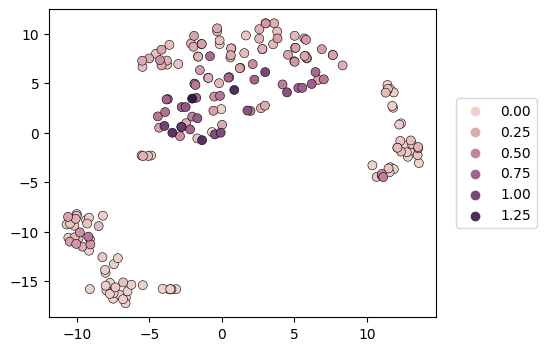

In [20]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(x=x_lase[mean_sort], y=y_lase[mean_sort], hue=mean[mean_sort], s=42, edgecolor="black", linewidth=0.4, ax=ax)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)
plt.savefig("./figures/lase_activity.pdf", bbox_inches='tight')
plt.show()

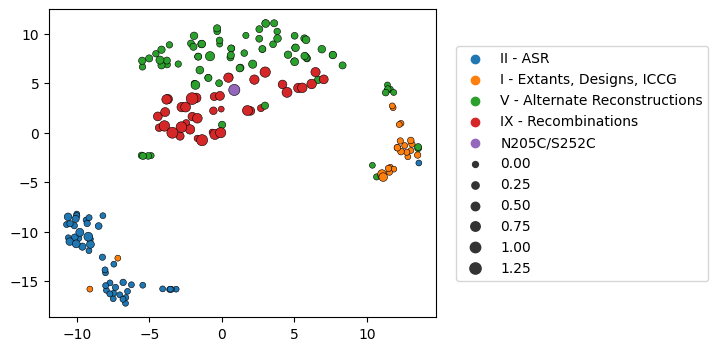

In [21]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(
    x=x_lase[mean_sort], 
    y=y_lase[mean_sort], 
    hue=np.array(phases)[mean_sort].tolist(), 
    size=mean[mean_sort], 
    edgecolor="black", linewidth=0.4, ax=ax,
    
)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
plt.show()

# Local Dirichlet energy over LASE space

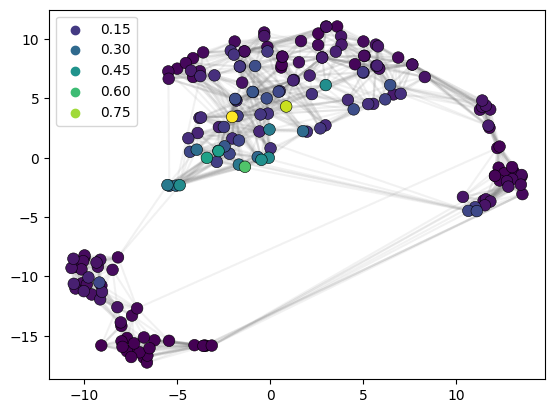

In [22]:
local_ens_lase, local_edge_lase_ls = get_local_dirichlet_energy(lase_seqs, np.array(mean))

# plot each edge
local_ens_sort = np.argsort(local_ens_lase)

for i in range(len(local_edge_lase_ls)):
    for idx in local_edge_lase_ls[i][0]:
        plt.plot([x_lase[i], x_lase[idx]], [y_lase[i], y_lase[idx]], color="grey", alpha=0.05)

sns.scatterplot(
    x=x_lase[local_ens_sort], 
    y=y_lase[local_ens_sort],
    hue=np.array(local_ens_lase)[local_ens_sort],
    zorder=5,
    palette="viridis",
    s=70,
    edgecolor="black", linewidth=0.4, 
)
plt.savefig("./figures/lase_dirichlet_energies.pdf", bbox_inches='tight')
plt.show()

In [23]:
# order of energies and coords
lase_energy_dict = {
    "Name": [],
    "Phase": [],
    "Fitness": [],
    "Local energy": [],
    "LASE tSNE x": [],
    "LASE tSNE y": []
}
for i in np.flip(local_ens_sort):
    lase_energy_dict["Name"].append(name_ls[i])
    lase_energy_dict["Phase"].append(phases[i])
    lase_energy_dict["Fitness"].append(mean[i])
    lase_energy_dict["Local energy"].append(np.round(local_ens_lase[i], 4))
    lase_energy_dict["LASE tSNE x"].append(np.round(x_lase[i], 4))
    lase_energy_dict["LASE tSNE y"].append(np.round(y_lase[i], 4))

pd.DataFrame(lase_energy_dict).to_csv("./data/LASE_local_dirichlet_energies.csv", index=False)